# 0. Bibliothèques utilisées

On importe l'ensemble des bibliothèques qui nous seront utiles au cours de ce projet

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
import splitfolders
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

ModuleNotFoundError: No module named 'splitfolders'

# 1. Création des dossiers contenant les fichiers d'entraînement, de validation et de test

Voici d'où provient notre dataset : https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

Il suffit de télécharger les données, de dé-zipper le dossier téléchargé et de placer notre notebook dans un même dossier contenant le dossier "brain_tumor_dataset".

### 1.1. On découpe notre dataset en dossiers : train (70%), validation (20%) et test(10%)

Afin de comparer les modèles, on fixe l'aléa (seed) pour avoir la même répartition après découpage au niveau du dataset. Cela nous donnera un résultat plus robuste concernant l'évaluation de la performance de l'architecture.

In [2]:
splitfolders.ratio('brain_tumor_dataset', output="./brain_tumor_dataset_split", ratio=(0.7, 0.2,0.1), seed = 7)

Copying files: 253 files [00:00, 341.27 files/s]


### 1.2. On crée des variables contenant le chemin de chaque dossier

In [3]:
train_dir = './brain_tumor_dataset_split/train'
validation_dir = './brain_tumor_dataset_split/val'
test_dir = './brain_tumor_dataset_split/test'

### 1.3. Même principe que précédemment, cette fois-ci avec les sous-dossiers

In [4]:
train_no_dir = './brain_tumor_dataset_split/train/no'
train_yes_dir = './brain_tumor_dataset_split/train/yes'
validation_no_dir = './brain_tumor_dataset_split/val/no'
validation_yes_dir = './brain_tumor_dataset_split/val/yes'
test_no_dir = './brain_tumor_dataset_split/test/no'
test_yes_dir = './brain_tumor_dataset_split/test/yes'

### 1.4. On procède à une vérification : on affiche le nombre de fichiers (images) contenus dans chaque sous dossier

In [5]:
print('total training no images:', len(os.listdir(train_no_dir)))
print('total training yes images:', len(os.listdir(train_yes_dir)))
print('\ntotal validation no images:', len(os.listdir(validation_no_dir)))
print('total validation yes images:', len(os.listdir(validation_yes_dir)))
print('\ntotal test no images:', len(os.listdir(test_no_dir)))
print('total test yes images:', len(os.listdir(test_yes_dir)))

somme = len(os.listdir(train_no_dir)) + len(os.listdir(train_yes_dir)) + len(os.listdir(validation_no_dir)) + len(os.listdir(validation_yes_dir)) + len(os.listdir(test_no_dir)) +  len(os.listdir(test_yes_dir))
print('\nNombre total de fichiers  :', somme) 

total training no images: 68
total training yes images: 108

total validation no images: 19
total validation yes images: 31

total test no images: 11
total test yes images: 16

Nombre total de fichiers  : 253


# 2. Implémentation de notre premier algorithme (normalisation et redimensionnement)

### 2.1. Initialisation du générateur pour modifier les images

Ici on normalise simplement notre image, ainsi la valeur des pixels passe de [0,255] à [0,1]

In [6]:
datagen_examp = ImageDataGenerator(rescale=1./255) 

### 2.2. Maintenant qu'on a initialisé notre générateur on l'implémente en lui indiquant où chercher les images

Pour nos données d'entrainement :

In [7]:
train_generator_examp = datagen_examp.flow_from_directory(  #flow_from_directory nous permet de charger des lots de données depuis un chemin de fichier
    train_dir, #chemin pour accéder aux fichiers
    batch_size=8, #taille du lot d’images à charger
    target_size=(150, 150), #redimensionnement des images chargées à 150x150
    class_mode='binary', #labellisation binaire : no ou yes 
    color_mode = 'grayscale') #On a des images en niveau de gris (NG)

Found 176 images belonging to 2 classes.


Pour nos données de validation :

In [8]:
validation_generator_examp = datagen_examp.flow_from_directory(
    validation_dir,
    batch_size=8,
    target_size=(150, 150),
    class_mode='binary',
    color_mode = 'grayscale')

Found 50 images belonging to 2 classes.


### 2.3. On vient vérifier que les lots d'images correspondent aux dimensions souhaitées

In [9]:
for data_batch_examp, labels_batch_examp in train_generator_examp:
 print('data batch shape:', data_batch_examp.shape) #On a bien des lots de 8 images de dimensions 150x150x1
 print('labels batch shape:', labels_batch_examp.shape) #On a également des lots de 8 labels, ‘no’ ou ‘yes’, un pour chaque image
 break #On veut juste une seule itération

data batch shape: (8, 150, 150, 1)
labels batch shape: (8,)


On vient également regarder l'encodage des deux classes :

In [10]:
train_generator_examp.class_indices

{'no': 0, 'yes': 1}

# 3. Construction de notre architecture (CNN) afin de l'appliquer à nos images

### 3.1. On définit notre architecture pour ensuite y ajouter des couches

In [11]:
modelCNN_examp = models.Sequential()

### 3.2. On ajoute les couches à notre architecture

#### Détails de la 1ère couche :
- 32 filtres/neurones donc la couche exécute l'action 32 fois, noyau de 3x3 (pixels) et pour chaque pixel de l'image car par défaut on a : strides = (1,1)
- En entrée on prend des images de taille 150x150 en niveau de gris (1)
- Cette couche produit 32 feature-maps possédant chacune des caractéristiques différentes de l’image

In [12]:
modelCNN_examp.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 1))) 

#### Détails de la 2ème couche :
- Elle est insérée entre deux couches et son rôle est de prendre les sorties de la première couche afin de les normaliser pour les transmettre comme entrées de la couche suivante.

In [13]:
modelCNN_examp.add(layers.BatchNormalization())

#### Détails de la 3ème couche : 
- Cette couche extrait des motifs, des tendances d’une donnée : la valeur la plus importante de chaque motif des feature-maps
- MaxPooling prend en entrée des feature-map pour en extraire la valeur max et ainsi garder seulement les informations importantes
- Pas besoin de préciser le nombre de filtres, il s'adapte à la fonction précédente par contre on a un noyau de taille 2x2

In [14]:
modelCNN_examp.add(layers.MaxPooling2D((2, 2)))

#### On complète notre architecture avec des couches supplémentaires :

In [15]:
modelCNN_examp.add(layers.Conv2D(16, (3, 3), activation='relu')) #4
modelCNN_examp.add(layers.BatchNormalization()) #5
modelCNN_examp.add(layers.Conv2D(8, (3, 3), activation='relu')) #6
modelCNN_examp.add(layers.BatchNormalization()) #7

#### Détails de la 8ème couche :
- Elle permet d'aplatir le tenseur et donc de réduire sa dimension à un vecteur (1-D)

In [16]:
modelCNN_examp.add(layers.Flatten())

#### Détails de la 9ème couche :
- Cette couche est une couche de prédiction qui permet de donner le label détecté par notre modèle
- Chaque neurone reçoit une entrée de tous les neurones de la couche précédente (fully connected)
- Ici 32 correspond à la dimension du vecteur en sortie de cette couche

In [17]:
modelCNN_examp.add(layers.Dense(32, activation='relu'))

#### On ajoute les dernières couches :

In [18]:
modelCNN_examp.add(layers.Dense(16, activation='relu')) #10
modelCNN_examp.add(layers.Dense(1, activation='sigmoid')) #11 couches au total

#### Rappel sur les fonctions d'activations : 

Une fonction d’activation permet modifier de manière non-linéaire les données afin de modifier spatialement leur représentation. Elle sert donc à changer notre vision de la donnée.

- La fonction 'relu' donne x si x est supérieur à 0, 0 sinon. Autrement dit, c’est le maximum entre x et 0. Elle conserve donc uniquement les valeurs positives. On l'applique très souvent un peu partout mais PAS à la fin

- La fonction 'sigmoïde' donne une probabilité donc une valeur comprise entre 0 et 1. Elle est très utilisée pour les classification binaire où l'on doit déterminer deux labels

### 3.3. On regarde la composition de notre architecture : les couches, les sorties et le nombre de paramètres

In [19]:
modelCNN_examp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 16)        4624      
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 70, 70, 8)         1160      
_________________________________________________________________
batch_normalization_2 (Batch (None, 70, 70, 8)         3

### 3.4. On compile le modèle : on configure son apprenissage

#### On vient préciser :
- Notre fonction coût
- L'optimisateur utilisé et son taux d'apprentissage
- La métrique

In [20]:
modelCNN_examp.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4), metrics=['AUC']) #ou Adam ou SGD

### 3.5. On vient entrainer le modèle

On définit une variable afin d'arrêter l'entraînement du modèle si on considère que la métrique cesse de s'améliorer (dans notre cas, stagne ou diminue). Cette variable est essentielle dans les "gros" projets pour permettre des économies de temps (en jours ou en mois) et en argent (milliers ou millions d'euros).
Ici on stoppe l'entraînement s'il n'y a pas d'améliorations sur les 15 prochaines "epochs" de la valeur de la fonction coût pour nos données de validation 'val_loss'

In [21]:
es_examp = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta = 0,
    patience=15)

C'est ici qu'on entraîne le modèle. C'est le même princique que .fit() mais avec des générateurs. 
On a :
- batch_size = 8
- train_len = 176

In [22]:
history_examp = modelCNN_examp.fit_generator(
    train_generator_examp, #chemin du fichier avec les données
    steps_per_epoch=18, #données divisées en 8 lots que le modèle teste un à un
    epochs=70, #Nombre de fois où le modèle s'entraîne sur les données
    validation_data=validation_generator_examp, #chemin du fichier contenant les données de validation
    callbacks=[es_examp])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/70
18/18 [==============================] - 7s 364ms/step - loss: 0.8406 - auc: 0.4408 - val_loss: 0.6925 - val_auc: 0.4864
Epoch 2/70
18/18 [==============================] - 6s 314ms/step - loss: 0.7022 - auc: 0.6308 - val_loss: 0.6892 - val_auc: 0.6757
Epoch 3/70
18/18 [==============================] - 6s 320ms/step - loss: 0.6268 - auc: 0.7337 - val_loss: 0.6941 - val_auc: 0.6537
Epoch 4/70
18/18 [==============================] - 6s 317ms/step - loss: 0.5516 - auc: 0.8263 - val_loss: 0.7000 - val_auc: 0.6825
Epoch 5/70
18/18 [==============================] - 6s 353ms/step - loss: 0.4874 - auc: 0.8953 - val_loss: 0.7095 - val_auc: 0.7080
Epoch 6/70
18/18 [==============================] - 6s 327ms/step - loss: 0.4654 - auc: 0.9217 - val_loss: 0.7133 - val_auc: 0.6401
Epoch 7/70
18/18 [==============================] - 5s 301ms/step - loss: 0.4284 - auc: 0.9386 - val_loss: 0.7148 - val_auc: 0.6774


### 3.6. Sauvegarde et réutilisation du modèle 

Sauvegarde de notre modèle pour ne pas le re-entraîner à chaque session

In [23]:
modelCNN_examp.save('model_trained_noDA.h5')

Si l'on souhaite réutiliser le modèle sauvegardé

In [24]:
#modelCNN_examp = models.load_model('model_trained_noDA.h5')

### 3.7. On évalue notre modèle en comparant les métriques, les courbes de loss et les courbes de précision

#### On définit nos métriques :

In [25]:
auc = history_examp.history['auc']
val_auc = history_examp.history['val_auc']

loss = history_examp.history['loss']
val_loss = history_examp.history['val_loss']

epochs = range(1, len(auc) + 1)

#### On affiche nos résultats

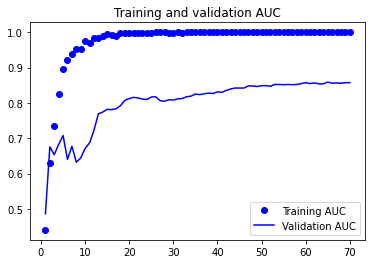

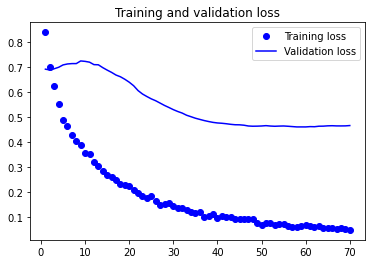

In [26]:
plt.plot(epochs, auc, 'bo', label='Training AUC')
plt.plot(epochs, val_auc, 'b', label='Validation AUC')
plt.title('Training and validation AUC')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 3.8. On vient tester notre modèle après entraînement et validation sur nos données de test

In [27]:
test_generator_examp = datagen_examp.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=8,
    class_mode='binary',
    color_mode="grayscale")

Found 27 images belonging to 2 classes.


In [28]:
modelCNN_examp.evaluate(test_generator_examp)

4/4 [==============================] - 0s 33ms/step - loss: 0.3410 - auc: 0.9318


[0.34102559089660645, 0.9318182468414307]

# 4. Implémentation de notre second algorithme avec Data Augmentation

La DA va nous permettre de modifier artificiellement les images de notre dataset (pour l'entraînement) en appliquant diverses transformations à ces dernières et donc d'augmenter la taille de notre training set artificiellement.
Cela nous permet d'augmenter considérablement la diversité des nos données pour nos modèles de formation, sans réellement collecter de nouvelles données. Plus globalement cela permet de limiter l'overfitting en généralisant mieux.

En effet le modèle et plus précisément notre réseau de neurones ne considèrera pas une image unique, elles seront considérées comme distinctes.

### 4.1. Exemple et affichage de DA avec un générateur

In [29]:
augmented_datagen_example = ImageDataGenerator(
    rotation_range = 40, #pivoter une image de façon aléatoire sur une plage entre 0 et 40°
    width_shift_range= 0.2, #plage afin redimensionner aléatoirement des images verticalement ou horizontalement
    height_shift_range = 0.2, #plage afin redimensionner aléatoirement des images verticalement ou horizontalement
    shear_range = 0.2, #plage permettant de rogner(découper) de manière aléatoire l’image
    zoom_range = 0.2, #pour zoomer de manière aléatoire à l’intérieur des images
    horizontal_flip = True, #retourne horizontalement des images de manière aléatoire
    fill_mode = 'nearest') #pour remplir les pixels nouvellement créés à la suite d'un pivotage, d'un rognage...

#### Affichage des images augmentées

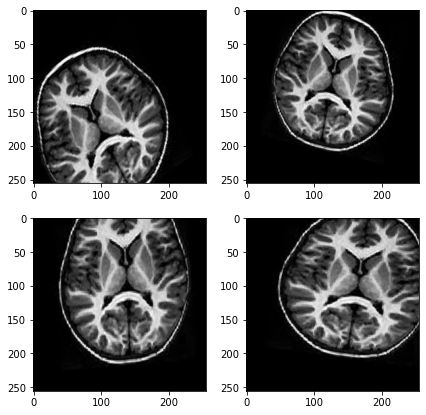

In [30]:
fnames = [os.path.join(train_no_dir, fname) for fname in os.listdir(train_no_dir)]

img_path = fnames[4]
img = image.load_img(img_path, target_size=(256, 256))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i=0
fig = plt.figure(figsize=(7,7))

for batch in augmented_datagen_example.flow(x, batch_size=1):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
     break

plt.show()

### 4.2. Choix d'un générateur pour notre étude

Pour observer les images augmentées précédemment, on a utilisé fill_mode. Cependant, ce n'est pas nécessaire pour l’entraînement du modèle. Egalement, on ne veut pas perdre le point d'intérêt de nos images (la tumeur) à travers certaines transformations, voilà pourquoi on initialise un générateur sans plusieurs paramètres.

In [31]:
augmented_datagen = ImageDataGenerator(
    rescale=1./255, #On vient également normaliser notre image
    rotation_range=60, #pivoter une image de façon aléatoire sur une plage entre 0 et 40°
    shear_range=0.1, #plage permettant de rogner(découper) de manière aléatoire l’image
    zoom_range=0.15, #pour zoomer de manière aléatoire à l’intérieur des images
    horizontal_flip = True, #retourne horizontalement des images de manière aléatoire
    vertical_flip = True) #retourne verticalement des images de manière aléatoire

La DA concerne seulement les données d’entraînement. Ainsi pour les autres données on initialise un générateur simplement pour normaliser les images.

In [32]:
datagen = ImageDataGenerator(rescale=1./255) #Ici on normalise simplement notre image, ainsi la valeur des pixels passe de [0,255] à [0,1]

#### Affichage des images augmentées avec le nouveau générateur

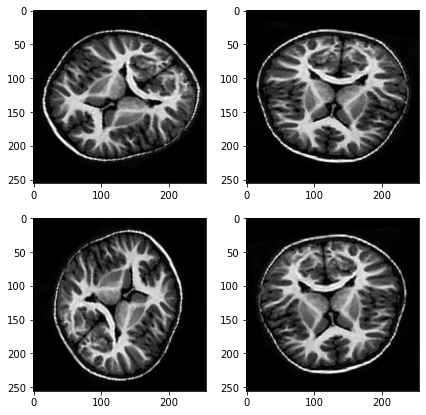

In [33]:
fnames = [os.path.join(train_no_dir, fname) for fname in os.listdir(train_no_dir)]

img_path = fnames[4]
img = image.load_img(img_path, target_size=(256, 256))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i=0
fig = plt.figure(figsize=(7,7))

for batch in augmented_datagen.flow(x, batch_size=1):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
     break

plt.show()

### 4.3. On implémente à nouveau les générateurs en indiquant où chercher les images

Pour les données d'entraînement : 

In [34]:
train_generator = augmented_datagen.flow_from_directory(
    train_dir, #chemin pour accéder aux fichiers
    target_size=(150, 150), #redimensionnement des images chargées à 150x150 
    batch_size=8, #taille du lot d’images à charger
    class_mode='binary', #labellisation binaire : no ou yes
    color_mode = "grayscale")

Found 176 images belonging to 2 classes.


Pour les données de validation :

In [35]:
validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=8,
    class_mode='binary',
    color_mode = "grayscale")

Found 50 images belonging to 2 classes.


### 4.4. On vient vérifier les dimensions des lots d'images

In [36]:
#Pour vérifier que les lots d’images créés correspondent aux dimensions voulu
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break #On veut juste une seule itération

data batch shape: (8, 150, 150, 1)
labels batch shape: (8,)


# 5. Construction d'une nouvelle architecture CNN 

### 5.1. On reprend les mêmes couches que précédemment 

In [37]:
modelCNN = models.Sequential()
modelCNN.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 1))) 
modelCNN.add(layers.BatchNormalization())
modelCNN.add(layers.MaxPooling2D((2, 2)))
modelCNN.add(layers.Conv2D(16, (3, 3), activation='relu'))
modelCNN.add(layers.BatchNormalization())
modelCNN.add(layers.Conv2D(8, (3, 3), activation='relu'))
modelCNN.add(layers.BatchNormalization())
modelCNN.add(layers.Flatten())

### 5.2. On introduit une nouvelle couche 
Avec la DA on peut produire de nouvelles informations, notamment en remaniant informations existantes à travers des opérations mathématiques (transformations d'images). Pour se débarasser complètement de l'overfitting, on fait donc appel à une couche supplémentaire : celle du Dropout

#### Détails de la nouvelle couche :
- Des poids sont associés aux neurones de chaque couche et ils représentent l’apprentissage du modèle : plus ils sont élevés, plus le neurone a d’influence sur la donnée
- Dropout permet de supprimer aléatoirement certains des neurones (ici 20%) et donc leur poids forçant les autres à se "surpasser"
- Concrètement, on ajoute du bruit pendant l’apprentissage du modèle afin de contraindre les neurones restant à être plus robustes et plus performants

In [38]:
modelCNN.add(layers.Dropout(0.2))

### 5.3. On conserve les couches finales de notre 1er algorithme 

In [39]:
modelCNN.add(layers.Dense(32, activation='relu'))
modelCNN.add(layers.Dense(16, activation='relu'))
modelCNN.add(layers.Dense(1, activation='sigmoid'))

### 5.4. On regarde plus en détails les informations liées à notre architecure 

In [40]:
#Observation générale de notre modèle et de ses couches
modelCNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
batch_normalization_3 (Batch (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 16)        4624      
_________________________________________________________________
batch_normalization_4 (Batch (None, 72, 72, 16)        64        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 70, 70, 8)         1160      
_________________________________________________________________
batch_normalization_5 (Batch (None, 70, 70, 8)        

### 5.4. On compile et entraîne notre nouveau modèle

In [41]:
modelCNN.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4), metrics=['AUC'])

In [42]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta = 0,
    patience=15)

In [43]:
history = modelCNN.fit_generator(
    train_generator, #chemin du fichier avec les données
    steps_per_epoch=18, #données divisées en 8 lots que le modèle teste un à un
    epochs=70, #Nombre de fois où le modèle s'entraîne sur les données
    validation_data=validation_generator, #chemin du fichier contenant les données de validation
    callbacks=[es]) #nombre de steps_per_epoch après lequel le modèle teste son apprentissage sur les données de validation

Epoch 1/70
18/18 [==============================] - 6s 350ms/step - loss: 0.7654 - auc: 0.4093 - val_loss: 0.6982 - val_auc: 0.6452
Epoch 2/70
18/18 [==============================] - 6s 331ms/step - loss: 0.7454 - auc: 0.5070 - val_loss: 0.7003 - val_auc: 0.7122
Epoch 3/70
18/18 [==============================] - 7s 363ms/step - loss: 0.6427 - auc: 0.6145 - val_loss: 0.6999 - val_auc: 0.7080
Epoch 4/70
18/18 [==============================] - 6s 317ms/step - loss: 0.6732 - auc: 0.5894 - val_loss: 0.6960 - val_auc: 0.6808
Epoch 5/70
18/18 [==============================] - 6s 324ms/step - loss: 0.6706 - auc: 0.6000 - val_loss: 0.6910 - val_auc: 0.6732
Epoch 6/70
18/18 [==============================] - 7s 375ms/step - loss: 0.6333 - auc: 0.6501 - val_loss: 0.6860 - val_auc: 0.6885
Epoch 7/70
18/18 [==============================] - 7s 380ms/step - loss: 0.6835 - auc: 0.5891 - val_loss: 0.6821 - val_auc: 0.7080
Epoch 8/70
18/18 [==============================] - 6s 321ms/step - loss: 0.

### 5.5 On sauvegarde une fois de plus notre modèle avec la possibilité de le réutiliser

La sauvegarde :

In [44]:
modelCNN.save('model_trained_augmented.h5')

La réutilisation :

In [45]:
#modelCNN = modelCNN.load_model('model_trained_augmented.h5')

### 5.6. On évalue notre modèle en comparant les métriques, les courbes de loss et les courbes de précision

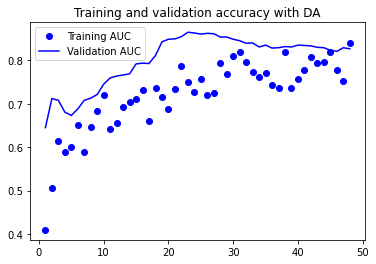

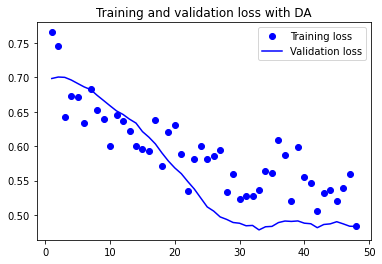

In [46]:
auc = history.history['auc']
val_auc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(auc) + 1)

plt.plot(epochs, auc, 'bo', label='Training AUC')
plt.plot(epochs, val_auc, 'b', label='Validation AUC')
plt.title('Training and validation accuracy with DA')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss with DA')
plt.legend()

plt.show()

### 5.7. On vient finalement tester le modèle sur nos données de test

In [47]:
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=8,
    class_mode='binary',
    color_mode="grayscale")

modelCNN.evaluate(test_generator)

Found 27 images belonging to 2 classes.
4/4 [==============================] - 0s 31ms/step - loss: 0.5543 - auc: 0.7756


[0.5542997717857361, 0.7755681872367859]

### 5.8. Statistiques générales sur les métriques

In [48]:
yes_train = np.count_nonzero(train_generator.classes)
no_train = len(train_generator.classes)-yes_train
print("Train Yes:",yes_train)
print("Train No:",no_train)

yes_test = np.count_nonzero(test_generator.classes)
no_test = len(test_generator.classes)-yes_test
print("Test Yes:",yes_test)
print("Test No:",no_test)

Train Yes: 108
Train No: 68
Test Yes: 16
Test No: 11


#### On s'intéresse à la matrice de confusion de notre algorithme sans DA

In [49]:
Y_true = test_generator.classes
Y_pred = (modelCNN_examp.predict(test_generator)>0.5).astype(int) #On prédit sur le test

In [50]:
print("Basic Model :")
print("Confusion matrix:")
print(confusion_matrix(Y_true,Y_pred))
print("Test Accuracy:",accuracy_score(Y_true,Y_pred))
print("Classification report:")
print(classification_report(Y_true,Y_pred))

Basic Model :
Confusion matrix:
[[ 3  8]
 [ 5 11]]
Test Accuracy: 0.5185185185185185
Classification report:
              precision    recall  f1-score   support

           0       0.38      0.27      0.32        11
           1       0.58      0.69      0.63        16

    accuracy                           0.52        27
   macro avg       0.48      0.48      0.47        27
weighted avg       0.50      0.52      0.50        27



#### On s'intéresse à la matrice de confusion de notre algorithme avec DA

In [51]:
Y_true_da = test_generator.classes
Y_pred_da = (modelCNN.predict(test_generator)>0.5).astype(int)

In [52]:
print("Model Augmented :")
print("Confusion matrix (DA):")
print(confusion_matrix(Y_true_da,Y_pred_da))
print("Test Accuracy:",accuracy_score(Y_true_da,Y_pred_da))
print("Classification report:")
print(classification_report(Y_true_da,Y_pred_da))

Model Augmented :
Confusion matrix:
[[ 6  5]
 [ 3 13]]
Test Accuracy: 0.7037037037037037
Classification report:
              precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.72      0.81      0.76        16

    accuracy                           0.70        27
   macro avg       0.69      0.68      0.68        27
weighted avg       0.70      0.70      0.70        27



# 6. Annexes (hors sujet/complémentaire)

### 6.1. Prédiction ponctuelle pour tester certaines images avec notre modèle

Appartient à la classe : 1


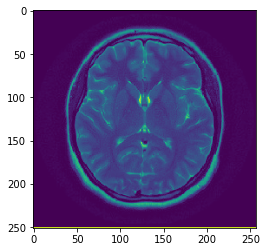

In [54]:
img = Image.open(r"MoreData/notum3.jpeg") #On charge une image
img = ImageOps.grayscale(img) #on la transforme en NG
x = np.array(img.resize((150,150)))
x = x.reshape(1,150,150,1)
res = modelCNN.predict_on_batch(x) #On applique notre modèle à l'image
plt.imshow(img) #On affiche
print("Appartient à la classe : "+str(modelCNN.predict_on_batch(x)[0][0].astype(int)))

### 6.2. Vérification du fichier test avec la méthode ponctuelle : on regarde si une image avec tumeur est bien considérée {1}

brain_tumor_dataset_split/test/yes\Y107.jpg
[[1.]]
brain_tumor_dataset_split/test/yes\Y11.jpg
[[1.]]
brain_tumor_dataset_split/test/yes\Y112.JPG
[[1.]]
brain_tumor_dataset_split/test/yes\Y115.JPG
[[1.]]
brain_tumor_dataset_split/test/yes\Y116.JPG
[[1.]]
brain_tumor_dataset_split/test/yes\Y13.jpg
[[1.]]
brain_tumor_dataset_split/test/yes\Y146.JPG
[[1.]]
brain_tumor_dataset_split/test/yes\Y162.jpg
[[1.]]
brain_tumor_dataset_split/test/yes\Y185.jpg
[[1.]]
brain_tumor_dataset_split/test/yes\Y254.jpg
[[1.]]
brain_tumor_dataset_split/test/yes\Y30.jpg
[[1.]]
brain_tumor_dataset_split/test/yes\Y38.jpg
[[1.]]
brain_tumor_dataset_split/test/yes\Y44.JPG
[[1.]]
brain_tumor_dataset_split/test/yes\Y49.JPG
[[1.]]
brain_tumor_dataset_split/test/yes\Y7.jpg
[[1.]]
brain_tumor_dataset_split/test/yes\Y78.jpg
[[1.]]


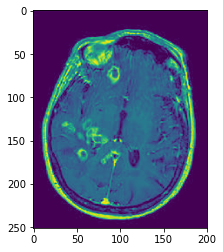

In [55]:
for file in glob.glob("brain_tumor_dataset_split/test/yes/*.jpg"):
    print(file)
    img = Image.open(file)
    img = ImageOps.grayscale(img)
    x = np.array(img.resize((150,150)))
    x = x.reshape(1,150,150,1)
    res = modelCNN.predict_on_batch(x)
    plt.imshow(img)
    print(modelCNN.predict_on_batch(x))

for file in glob.glob("brain_tumor_dataset_split/test/yes/*.png"):
    print(file)
    img = Image.open(file)
    img = ImageOps.grayscale(img)
    x = np.array(img.resize((150,150)))
    x = x.reshape(1,150,150,1)
    res = modelCNN.predict_on_batch(x)
    plt.imshow(img)
    print(modelCNN.predict_on_batch(x))

for file in glob.glob("brain_tumor_dataset_split/test/yes/*.jpeg"):
    print(file)
    img = Image.open(file)
    img = ImageOps.grayscale(img)
    x = np.array(img.resize((150,150)))
    x = x.reshape(1,150,150,1)
    res = modelCNN.predict_on_batch(x)
    plt.imshow(img)
    print(modelCNN.predict_on_batch(x))

### 6.3. Même principe de vérification, cette fois-ci pour des images sans tumeur donc {0}

brain_tumor_dataset_split/test/no\15 no.jpg
[[1.]]
brain_tumor_dataset_split/test/no\17 no.jpg
[[1.]]
brain_tumor_dataset_split/test/no\19 no.jpg
[[0.00026077]]
brain_tumor_dataset_split/test/no\21 no.jpg
[[1.]]
brain_tumor_dataset_split/test/no\28 no.jpg
[[1.]]
brain_tumor_dataset_split/test/no\7 no.jpg
[[1.]]
brain_tumor_dataset_split/test/no\N11.jpg
[[1.]]
brain_tumor_dataset_split/test/no\no 4.jpg
[[1.]]
brain_tumor_dataset_split/test/no\no 98.jpg
[[1.]]
brain_tumor_dataset_split/test/no\no 9.png
[[1.]]
brain_tumor_dataset_split/test/no\48 no.jpeg
[[1.]]


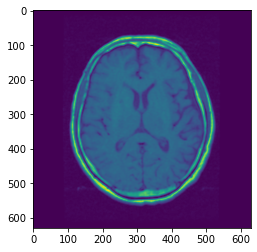

In [56]:
for file in glob.glob("brain_tumor_dataset_split/test/no/*.jpg"):
    print(file)
    img = Image.open(file)
    img = ImageOps.grayscale(img)
    x = np.array(img.resize((150,150)))
    x = x.reshape(1,150,150,1)
    res = modelCNN.predict_on_batch(x)
    plt.imshow(img)
    print(modelCNN.predict_on_batch(x))

for file in glob.glob("brain_tumor_dataset_split/test/no/*.png"):
    print(file)
    img = Image.open(file)
    img = ImageOps.grayscale(img)
    x = np.array(img.resize((150,150)))
    x = x.reshape(1,150,150,1)
    res = modelCNN.predict_on_batch(x)
    plt.imshow(img)
    print(modelCNN.predict_on_batch(x))

for file in glob.glob("brain_tumor_dataset_split/test/no/*.jpeg"):
    print(file)
    img = Image.open(file)
    img = ImageOps.grayscale(img)
    x = np.array(img.resize((150,150)))
    x = x.reshape(1,150,150,1)
    res = modelCNN.predict_on_batch(x)
    plt.imshow(img)
    print(modelCNN.predict_on_batch(x))